In [100]:
import requests
import json
import time
from typing import List, Dict, Any
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Считываем массив, куда уже добавлен столбец целевой переменной (цена за квадратный метр) и столбцы среднего рейтинга по обьектам в районе.

In [101]:
arr = pd.read_csv('n.csv', index_col=0)

Удалим данные про парки, так как информация про них считалась не совсем корректно.

In [102]:
del arr['average_rating_parks_in_area'], arr['number_of_parks']

Один застройщик ЛСР назван по разному у разных квартир. Меняем всё на одно название.

In [103]:
mask = arr['developer'].str.contains('ЛСР', case=False, na=False)

arr.loc[mask, 'developer'] = 'Группа ЛСР'

In [104]:
arr.isna().sum()

,0
price_million_rub,0
complex_name,592
developer,1402
apartment_segment,592
floor,0
total_floors_in_building,0
number_of_rooms,1368
total_area_m2,0
living_area,196
kitchen_area,1536


In [105]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info[missing_info['Количество пропусков'] > 0]

,Количество пропусков,Процент
average_rating_museum_in_area,3505,33.289011
kitchen_area,1536,14.588280
developer,1402,13.315605
number_of_rooms,1368,12.992687
apartment_segment,592,5.622566
complex_name,592,5.622566
average_rating_shopping_center_in_area,525,4.986229
living_area,196,1.861525
street_house,83,0.788299
average_rating_business_center_in_area,2,0.018995


/tmp/ipython-input-932792783.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




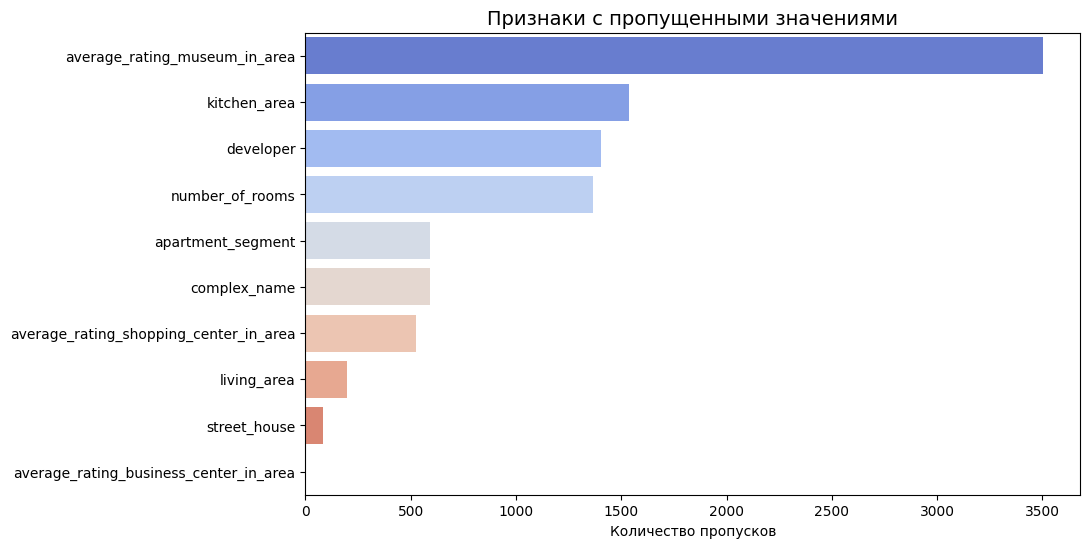

In [106]:
plt.figure(figsize=(10, 6))

#Отбираем только признаки с пропусками
missing_nonzero = missing_info[missing_info['Количество пропусков'] > 0]

sns.barplot(
    x='Количество пропусков',
    y=missing_nonzero.index,
    data=missing_nonzero,
    palette='coolwarm'
)

plt.title('Признаки с пропущенными значениями', fontsize=14)
plt.xlabel('Количество пропусков')
plt.ylabel('')
plt.show()


В признаке 'developer' у нас 1402 пропуска. Посмотрим на названия комплексов, у которых пропущен застройщик:

In [107]:
arr[arr['developer'].isna()]['complex_name'].value_counts()

,count
complex_name,
ЖК «Обручев»,221
ЖК SOLOS,141
ЖК Indy Towers (Инди Тауэрз),101
Квартал Мираполис,82
ЖК «Аквилон Signal»,80
ЖК «Петровский парк II»,38
МФК Дом Дау,33
ЖК RAKURS (РАКУРС),27
ЖК Sokolinn Park,23


In [108]:
len(arr[arr['developer'].isna()]['complex_name'].value_counts())

19

/tmp/ipython-input-1318808428.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




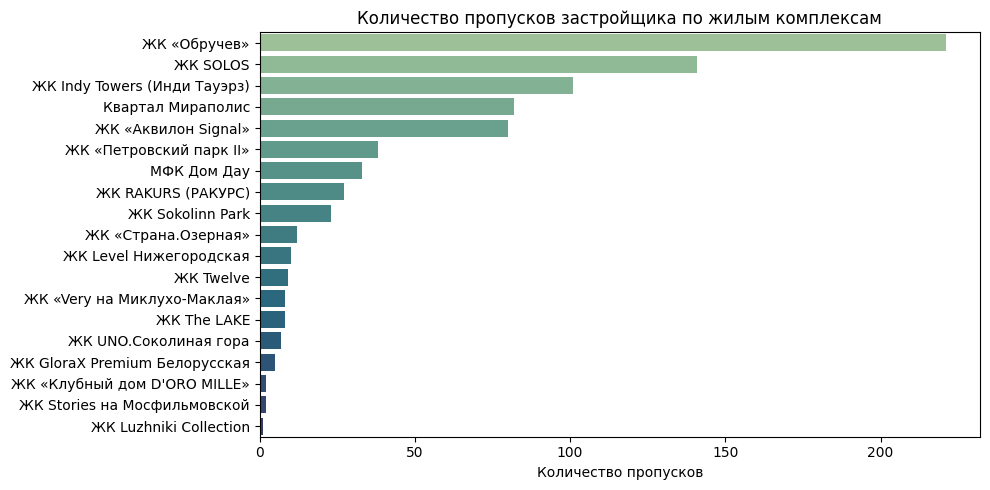

In [109]:
missing_developer = arr[arr['developer'].isna()]['complex_name'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_developer.values, y=missing_developer.index, palette='crest')
plt.title('Количество пропусков застройщика по жилым комплексам')
plt.xlabel('Количество пропусков')
plt.ylabel('')
plt.tight_layout()
plt.show()

Всего таких комплексов 19, заполним для них застройщиков по информации из интернета.

In [110]:
a = arr['developer'].dropna().copy()

In [111]:
a[a.str.contains('Absolute Premium')]

,developer


+ ЖК «Обручев»: Группа ЛСР
+ ЖК SOLOS: Dar (Дар)
+ ЖК Indy Towers (Инди Тауэрз): Группа «Аквилон»
+ Квартал Мираполис: ГК «Основа»
+ ЖК «Аквилон Signal»: Группа «Аквилон»
+ ЖК «Петровский парк II»: РГ-Девелопмент
+ МФК Дом Дау: ГК «Сумма элементов»
+ ЖК RAKURS (РАКУРС): Dar (Дар)
+ ЖК Sokolinn Park: Группа «Эталон»
+ ЖК «Страна.Озерная»: Страна Девелопмент
+ ЖК Level Нижегородская: Level Group
+ ЖК Twelve: TEKTA GROUP
+ ЖК «Very на Миклухо-Маклая»: ГК «Основа»
+ ЖК The LAKE: ГК «ФСК»
+ ЖК UNO.Соколиная гора: ГК «Основа»
+ ЖК GloraX Premium Белорусская: GloraX
+ ЖК «Клубный дом D'ORO MILLE»: СЗ ЭЛИТА-ЭКО
+ ЖК Stories на Мосфильмовской: October Group
+ ЖК Luzhniki Collection: Absolute Premium

In [112]:
developer_mapping = {
    'ЖК «Обручев»': 'Группа ЛСР',
    'ЖК SOLOS': 'Dar (Дар)',
    'ЖК Indy Towers (Инди Тауэрз)': 'Группа «Аквилон»',
    'Квартал Мираполис': 'ГК «Основа»',
    'ЖК «Аквилон Signal»': 'Группа «Аквилон»',
    'ЖК «Петровский парк II»': 'РГ-Девелопмент',
    'МФК Дом Дау': 'ГК «Сумма элементов»',
    'ЖК RAKURS (РАКУРС)': 'Dar (Дар)',
    'ЖК Sokolinn Park': 'Группа «Эталон»',
    'ЖК «Страна.Озерная»': 'Страна Девелопмент',
    'ЖК Level Нижегородская': 'Level Group',
    'ЖК Twelve': 'TEKTA GROUP',
    'ЖК «Very на Миклухо-Маклая»': 'ГК «Основа»',
    'ЖК The LAKE': 'ГК «ФСК»',
    'ЖК UNO.Соколиная гора': 'ГК «Основа»',
    'ЖК GloraX Premium Белорусская': 'GloraX',
    'ЖК «Клубный дом D\'ORO MILLE»': 'СЗ ЭЛИТА-ЭКО',
    'ЖК Stories на Мосфильмовской': 'October Group',
    'ЖК Luzhniki Collection': 'Absolute Premium'
}

for complex_name, developer in developer_mapping.items():

    mask = (arr['developer'].isna()) & (arr['complex_name'] == complex_name)
    arr.loc[mask, 'developer'] = developer

In [113]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info[missing_info['Количество пропусков'] > 0]

,Количество пропусков,Процент
average_rating_museum_in_area,3505,33.289011
kitchen_area,1536,14.588280
number_of_rooms,1368,12.992687
apartment_segment,592,5.622566
complex_name,592,5.622566
developer,592,5.622566
average_rating_shopping_center_in_area,525,4.986229
living_area,196,1.861525
street_house,83,0.788299
average_rating_business_center_in_area,2,0.018995


Теперь в столбац 'developer', 'apartment_segment' и 'complex_name' одинаковое число пропусков - по 592. Глядя на эти квартиры на сайте, с которого парсились данные, можно понять, что все эти квратиры - вторичные, поэтому эти данные на сайте не указаны для них.

Таким образом, заполним эти пропуски в трёх столбцах значением "Вторичная квартира"  

/tmp/ipython-input-2060726807.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




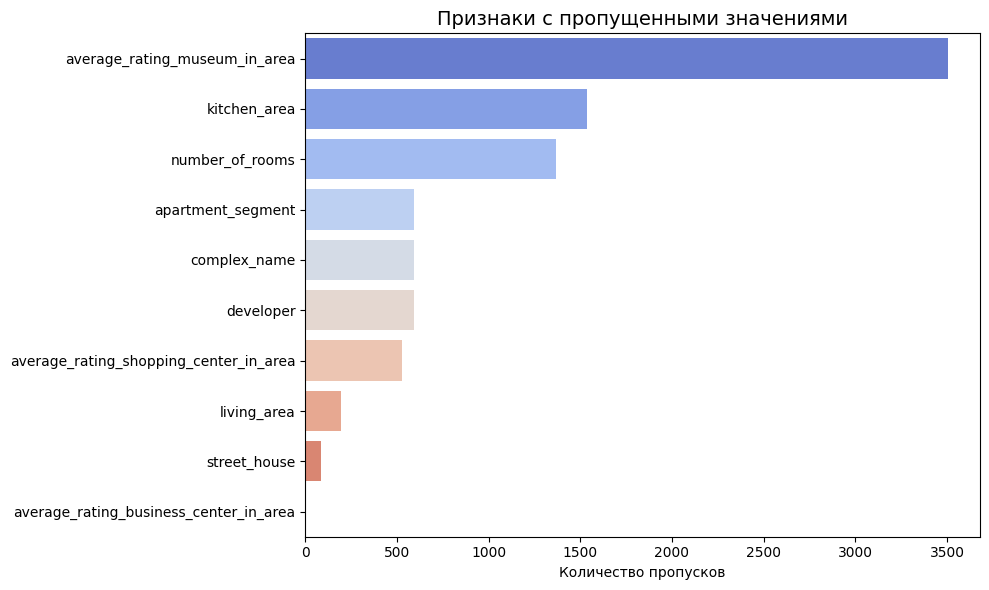

In [114]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info = missing_info[missing_info['Количество пропусков'] > 0]

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Количество пропусков',
    y=missing_info.index,
    data=missing_info,
    palette='coolwarm'
)

plt.title('Признаки с пропущенными значениями', fontsize=14)
plt.xlabel('Количество пропусков')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [115]:
arr['developer'] = arr['developer'].fillna('Вторичная квартира')

In [116]:
arr['complex_name'] = arr['complex_name'].fillna('Вторичная квартира')
arr['apartment_segment'] = arr['apartment_segment'].fillna('Вторичная квартира')

In [117]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info[missing_info['Количество пропусков'] > 0]

,Количество пропусков,Процент
average_rating_museum_in_area,3505,33.289011
kitchen_area,1536,14.588280
number_of_rooms,1368,12.992687
average_rating_shopping_center_in_area,525,4.986229
living_area,196,1.861525
street_house,83,0.788299
average_rating_business_center_in_area,2,0.018995


Пропуски в столбцах 'average_rating_museum_in_area', 'average_rating_shopping_center_in_area' и 'average_rating_business_center_in_area' появились из-за того, что в регионе, где пропуски по среднему рейтингу какого-либо объекта (музеев, парков,торговых центров или бизне-центров), нет ни одного этого объекта (из того, что мы считали, что было доступно) и поэтому нет и рейтинга.

Оставим эти пропуски и ничем не будем заменять, так как NaNы не будут мешать дальнейшей работе.

В признаке 'number_of_rooms' 1368 пропусков. Просмотрев эти квартиры на сайте, откуда был произведен парсинг, мы поянли, что числа комнат нет у квартир-студий (в объявлении эти квартиры заявлены, как студии). Поставим этим квартирам в признак 'number_of_rooms' значение 0.

In [118]:
arr['number_of_rooms'] = arr['number_of_rooms'].fillna(0)

In [119]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info[missing_info['Количество пропусков'] > 0]

,Количество пропусков,Процент
average_rating_museum_in_area,3505,33.289011
kitchen_area,1536,14.588280
average_rating_shopping_center_in_area,525,4.986229
living_area,196,1.861525
street_house,83,0.788299
average_rating_business_center_in_area,2,0.018995


/tmp/ipython-input-3006266181.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




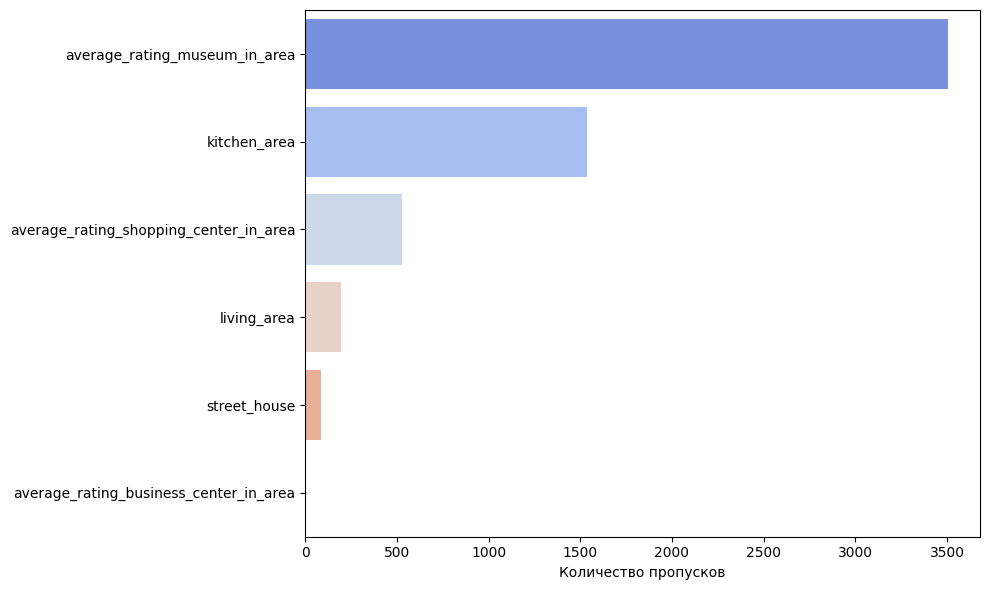

In [120]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info = missing_info[missing_info['Количество пропусков'] > 0]

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Количество пропусков',
    y=missing_info.index,
    data=missing_info,
    palette='coolwarm'
)

plt.title('', fontsize=14)
plt.xlabel('Количество пропусков')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [121]:
arr[(arr['living_area'].isna())]

,price_million_rub,complex_name,developer,apartment_segment,floor,total_floors_in_building,number_of_rooms,total_area_m2,living_area,kitchen_area,...,population_density_per_km2,average_rating_business_center_in_area,average_rating_kindergarten_in_area,average_rating_cafe_in_area,average_rating_store_in_area,average_rating_museum_in_area,average_rating_clinic_in_area,average_rating_shopping_center_in_area,average_rating_school_in_area,price_per_m2_million_rub
313,38.02,ЖК «Театральный квартал»,Концерн «КРОСТ»,Премиум класс,10.0,19.0,2.0,59.60,NaN,11.80,...,10622.64,4.630000,4.462069,4.111628,4.448889,4.800000,3.230000,NaN,3.969565,0.637919
1426,38.51,ЖК «Театральный квартал»,Концерн «КРОСТ»,Премиум класс,17.0,24.0,2.0,59.70,NaN,13.30,...,10622.64,4.630000,4.462069,4.111628,4.448889,4.800000,3.230000,NaN,3.969565,0.645059
1650,26.17,ЖК «Квартал на воде»,Группа «Самолет»,Бизнес класс,9.0,10.0,2.0,68.94,NaN,31.48,...,5005.25,4.166667,4.416667,4.015385,4.078947,2.800000,3.333333,4.240000,3.625000,0.379605
2272,38.94,ЖК «Театральный квартал»,Концерн «КРОСТ»,Премиум класс,22.0,24.0,2.0,62.20,NaN,15.40,...,10622.64,4.630000,4.462069,4.111628,4.448889,4.800000,3.230000,NaN,3.969565,0.626045
2360,41.08,ЖК «Театральный квартал»,Концерн «КРОСТ»,Премиум класс,19.0,19.0,2.0,63.30,NaN,19.30,...,10622.64,4.630000,4.462069,4.111628,4.448889,4.800000,3.230000,NaN,3.969565,0.648973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,29.93,Вторичная квартира,Вторичная квартира,Вторичная квартира,18.0,19.0,3.0,81.80,NaN,NaN,...,10504.98,3.866667,4.507143,3.529412,4.500000,NaN,2.166667,4.150000,4.642857,0.365892
10504,46.14,Вторичная квартира,Вторичная квартира,Вторичная квартира,7.0,15.0,1.0,49.70,NaN,NaN,...,8275.56,4.734884,4.409524,4.508000,4.258333,4.809091,3.983333,4.361538,4.150000,0.928370
10508,19.15,ЖК N`ICE LOFT (Найс Лофт),COLDY,Бизнес класс,16.0,21.0,2.0,56.40,NaN,NaN,...,6689.17,4.357143,4.437500,3.323077,4.187179,NaN,3.100000,4.433333,4.357143,0.339539
10509,32.79,Вторичная квартира,Вторичная квартира,Вторичная квартира,11.0,24.0,1.0,52.44,NaN,NaN,...,12799.31,4.752273,4.590909,4.434000,4.374468,4.688889,3.685714,4.628571,4.708333,0.625286


In [122]:
arr[(arr['number_of_rooms'] == 0) & arr['kitchen_area'].isna()]

,price_million_rub,complex_name,developer,apartment_segment,floor,total_floors_in_building,number_of_rooms,total_area_m2,living_area,kitchen_area,...,population_density_per_km2,average_rating_business_center_in_area,average_rating_kindergarten_in_area,average_rating_cafe_in_area,average_rating_store_in_area,average_rating_museum_in_area,average_rating_clinic_in_area,average_rating_shopping_center_in_area,average_rating_school_in_area,price_per_m2_million_rub
1,25.18,Квартал «Серебряный бор»,StMichael,Бизнес класс,7.0,25.0,0.0,24.07,14.56,NaN,...,14367.49,4.766667,4.452381,4.165789,4.357447,5.000000,2.740000,4.580000,4.195000,1.046115
3,12.61,ЖК «BeLuck Коломенское»,ГК «Гранель»,Комфорт класс,16.0,32.0,0.0,32.36,23.56,NaN,...,10206.85,4.130769,4.440000,4.105000,4.377273,5.000000,3.300000,4.283333,4.207143,0.389679
4,14.11,ЖК VEER,MR Group,Бизнес класс,6.0,22.0,0.0,22.20,14.35,NaN,...,13603.08,4.652632,4.234615,3.864516,4.548936,NaN,2.300000,4.625000,3.866667,0.635586
22,20.65,Жилой квартал «LIFE Варшавская»,ГК «Пионер» (Pioneer),Бизнес класс,8.0,25.0,0.0,33.63,21.24,NaN,...,9351.51,4.450000,4.587500,4.155556,4.553333,NaN,2.714286,4.250000,4.458333,0.614035
25,14.89,ЖК «Инсайдер»,ГК «РКС Девелопмент»,Бизнес класс,4.0,16.0,0.0,30.30,21.06,NaN,...,8275.56,4.734884,4.409524,4.508000,4.258333,4.809091,3.983333,4.361538,4.150000,0.491419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10431,19.47,Вторичная квартира,Вторичная квартира,Вторичная квартира,4.0,43.0,0.0,30.20,13.20,NaN,...,6840.78,4.725000,3.550000,3.712500,4.351163,5.000000,3.687500,4.470000,4.160000,0.644702
10434,11.77,Вторичная квартира,Вторичная квартира,Вторичная квартира,10.0,19.0,0.0,27.20,NaN,NaN,...,10504.98,3.866667,4.507143,3.529412,4.500000,NaN,2.166667,4.150000,4.642857,0.432721
10443,15.53,Вторичная квартира,Вторичная квартира,Вторичная квартира,7.0,41.0,0.0,33.49,NaN,NaN,...,5875.10,4.327273,4.560000,3.991667,4.446667,5.000000,2.733333,4.628571,4.500000,0.463721
10489,16.10,Вторичная квартира,Вторичная квартира,Вторичная квартира,14.0,41.0,0.0,33.54,NaN,NaN,...,5875.10,4.327273,4.560000,3.991667,4.446667,5.000000,2.733333,4.628571,4.500000,0.480024


У 99 из 1368 студей заполнен признак 'kitchen_area'.

В итоге пропуски в kitchen_area и living_area есть у квартир-студий и у обычных и нет возможности конкретно понять как их заполнить. Удалим эти признаки

In [123]:
arr[arr['street_house'].isna()][['address', 'street_house', 'complex_name']]

,address,street_house,complex_name
68,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,CRYSTAL Трилогия
78,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
430,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,CRYSTAL Трилогия
887,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
1028,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
...,...,...,...
9338,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
9400,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
9408,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,ЖК «Театральный квартал»
9420,"Москва, СЗАО, район Хорошёво-Мнёвники",NaN,CRYSTAL Трилогия


In [124]:
arr[arr['street_house'].isna()]['complex_name'].value_counts()

,count
complex_name,
ЖК «Театральный квартал»,36
CRYSTAL Трилогия,31
Жилой квартал Shagal («Шагал»),2
Вторичная квартира,1
ЖК «Level Кутузовский»,1
ЖК «Савеловский Сити»,1
ЖК «ЗИЛАРТ»,1
ЖК «Тимирязевский»,1
ЖК «Режиссер»,1


Удалим столбец 'street_house', так как этот столбец не будет учитываться при анализе целевой переменной.

In [125]:
del arr['street_house']

In [126]:
missing_data = arr.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(arr)) * 100
missing_info = pd.DataFrame({'Количество пропусков': missing_data, 'Процент': missing_percent})
missing_info[missing_info['Количество пропусков'] > 0]

,Количество пропусков,Процент
average_rating_museum_in_area,3505,33.289011
kitchen_area,1536,14.588280
average_rating_shopping_center_in_area,525,4.986229
living_area,196,1.861525
average_rating_business_center_in_area,2,0.018995


Сохраним датасет после обработки пропусков.

In [127]:
arr.to_csv('arrWITHOUT.csv')

In [128]:
arr1 = arr.copy()

In [129]:
arr1.columns

Index(['price_million_rub', 'complex_name', 'developer', 'apartment_segment',
       'floor', 'total_floors_in_building', 'number_of_rooms', 'total_area_m2',
       'living_area', 'kitchen_area', 'address',
       'distance_to_nearby_metro_stations', 'nearby_metro_stations',
       'nearest_metro', 'distance_to_nearest_metro', 'number_of_views', 'link',
       'city', 'administrative_district', 'area', 'number_of_business_centers',
       'number_of_kindergartens', 'number_of_cafes', 'number_of_stores',
       'number_of_museums', 'number_of_clinics', 'number_of_shopping_centers',
       'number_of_schools', 'area_size_km2', 'population',
       'population_density_per_km2', 'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_are

Удалим ненужные столбцы.

In [130]:
del arr1['distance_to_nearby_metro_stations'], arr1['address'], arr1['price_million_rub'], arr1['city']

In [131]:
arr1.columns

Index(['complex_name', 'developer', 'apartment_segment', 'floor',
       'total_floors_in_building', 'number_of_rooms', 'total_area_m2',
       'living_area', 'kitchen_area', 'nearby_metro_stations', 'nearest_metro',
       'distance_to_nearest_metro', 'number_of_views', 'link',
       'administrative_district', 'area', 'number_of_business_centers',
       'number_of_kindergartens', 'number_of_cafes', 'number_of_stores',
       'number_of_museums', 'number_of_clinics', 'number_of_shopping_centers',
       'number_of_schools', 'area_size_km2', 'population',
       'population_density_per_km2', 'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area', 'price_per_m2_million_rub'],
      dtype='object')

Добавим признак "count_of_nearby_metro", который показывает количество метро рядом с жк. Для этого посчитаем число станций в признаке 'nearby_metro_stations'.

In [132]:
def parse_metro_stations(station_str):
    if isinstance(station_str, list):
        return station_str
    elif isinstance(station_str, str):
        # Убираем квадратные скобки и кавычки, разделяем по запятым
        cleaned = station_str.strip("[]'\"")
        stations = [s.strip().strip("'\"") for s in cleaned.split(',')]
        return [s for s in stations if s]  # Убираем пустые строки
    else:
        return []

arr1['metro_stations_nearby'] = arr1['nearby_metro_stations'].apply(parse_metro_stations)
arr1['count_of_nearby_metro'] = arr1['metro_stations_nearby'].apply(len)

Теперь можно удалить признак 'nearby_metro_stations', так как вместо него теперь 'metro_stations_nearby'.

In [133]:
del arr1['nearby_metro_stations']

In [134]:
arr1.columns

Index(['complex_name', 'developer', 'apartment_segment', 'floor',
       'total_floors_in_building', 'number_of_rooms', 'total_area_m2',
       'living_area', 'kitchen_area', 'nearest_metro',
       'distance_to_nearest_metro', 'number_of_views', 'link',
       'administrative_district', 'area', 'number_of_business_centers',
       'number_of_kindergartens', 'number_of_cafes', 'number_of_stores',
       'number_of_museums', 'number_of_clinics', 'number_of_shopping_centers',
       'number_of_schools', 'area_size_km2', 'population',
       'population_density_per_km2', 'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area', 'price_per_m2_million_rub',
       'metro_stations_nearby', 'count_of_nearby_metro'],
      dtype='object

Закодируем категориальные признаки, чтобы использовать их в дальнейшем анализе корреляций.

Закодируем признак 'apartment_segment' с помощью метода Label Encoding, так как этот признак имеет всего 6 уникальных значения и поэтому ложных зависимостей не возникнет.

In [135]:
arr1['apartment_segment'].value_counts()

,count
apartment_segment,
Бизнес класс,6564
Премиум класс,1571
Комфорт класс,1256
Вторичная квартира,592
Элит класс,521
Эконом класс,25


In [136]:
apartment_segment_order = {
    'Премиум класс': 4,
    'Элит класс': 3,
    'Бизнес класс': 2,
    'Комфорт класс': 1,
    'Эконом класс': 0,
    'Вторичная квартира': -1
}

arr1['apartment_segment_encoded'] = arr1['apartment_segment'].map(apartment_segment_order)

Категориальные признаки 'complex_name', 'developer', 'area', 'administrative_district', 'nearest_metro' закодируем с помощью Target Encoding. Значениями признака будет средняя цена за квадратный метр по соответствующему названию комплекса, застройщика, региона или административного округа.

In [137]:
# Target Encoding для застройщика
developer_price_mean = arr1.groupby('developer')['price_per_m2_million_rub'].mean().to_dict()
arr1['developer_encoded'] = arr1['developer'].map(developer_price_mean)

# Target Encoding для названия комплексов
complex_name_price_mean = arr1.groupby('complex_name')['price_per_m2_million_rub'].mean().to_dict()
arr1['complex_name_encoded'] = arr1['complex_name'].map(complex_name_price_mean)

# Target Encoding для регионов
area_price_mean = arr1.groupby('area')['price_per_m2_million_rub'].mean().to_dict()
arr1['area_encoded'] = arr1['area'].map(area_price_mean)

# Target Encoding для административных округов
administrative_district_price_mean = arr1.groupby('administrative_district')['price_per_m2_million_rub'].mean().to_dict()
arr1['administrative_district_encoded'] = arr1['administrative_district'].map(administrative_district_price_mean)

# Target Encoding для станций метро
nearest_metro_price_mean = arr1.groupby('nearest_metro')['price_per_m2_million_rub'].mean().to_dict()
arr1['nearest_metro_encoded'] = arr1['nearest_metro'].map(nearest_metro_price_mean)


________________________________________________________________________________________________________________________

Поработаем с инфраструктурными признаками.

Так как все районы Москвы имеют разную площадь, изменим все признаки типа number_of_... в признак number_of_..._per_km2, который будет показывать число объектов на квадратный метр.

In [138]:
for feature in ['number_of_business_centers', 'number_of_kindergartens',
    'number_of_cafes', 'number_of_stores', 'number_of_museums', 'number_of_clinics', 'number_of_shopping_centers',
    'number_of_schools']:
    new_feature_name = feature + '_per_km2'
    arr1[new_feature_name] = arr1[feature] / arr1['area_size_km2']


In [139]:
del arr1['number_of_business_centers'], arr1['number_of_kindergartens'], arr1['number_of_cafes'], arr1['number_of_stores'], arr1['number_of_museums'], arr1['number_of_clinics'], arr1['number_of_shopping_centers'], arr1['number_of_schools']


Также добавим признак 'average_infrustructure_rating_in_area' - средняя оценка инфраструткры в районе.

In [140]:
arr1['average_infrustructure_rating_in_area'] = arr1[['average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area', 'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area']].mean(axis=1)

Добавим новый признак 'infrustructure_score', который будет учитывать не только, количесвто, но и качество инфраструктуры, а также доступность транспортной инфраструктуры.

In [141]:
# Колонки с количеством объектов
density_columns = [
    'number_of_business_centers_per_km2',
    'number_of_kindergartens_per_km2',
    'number_of_cafes_per_km2',
    'number_of_stores_per_km2',
    'number_of_museums_per_km2',
    'number_of_clinics_per_km2',
    'number_of_shopping_centers_per_km2',
    'number_of_schools_per_km2'
]

# Веса для каждого типа объектов
weights = [0.09, 0.16, 0.12, 0.18, 0.06, 0.14, 0.10, 0.15]

# Колонки с рейтингами объектов
rating_columns = [
    'average_rating_business_center_in_area',
    'average_rating_kindergarten_in_area',
    'average_rating_cafe_in_area',
    'average_rating_store_in_area',
    'average_rating_museum_in_area',
    'average_rating_clinic_in_area',
    'average_rating_shopping_center_in_area',
    'average_rating_school_in_area'
]

# 1. Умножаем количество объектов на вес и на их рейтинги
weighted_scores = []
for i in range(len(density_columns)):
    quantity = arr1[density_columns[i]]  # количество объектов
    rating = arr1[rating_columns[i]]     # рейтинг объектов
    weight = weights[i]
    weighted_score = quantity * weight * rating   # умножаем количество на качество
    weighted_scores.append(weighted_score)

# 2. Суммируем все взвешенные оценки
weighted_df = pd.concat(weighted_scores, axis=1)
infrastructure_raw_score = weighted_df.sum(axis=1)

# 3. Рассчитываем среднее расстояние до метро по каждому району
avg_metro_by_area = arr1.groupby('area')['distance_to_nearest_metro'].mean()

# 4. Добавляем среднее расстояние до метро к основным данным
arr1['avg_distance_to_metro_in_area'] = arr1['area'].map(avg_metro_by_area)

# 5. Добавляем фактор метро (чем ближе - тем лучше)
# Нормализуем chtlytt расстояние до метро по району
metro_min = arr1['avg_distance_to_metro_in_area'].min()
metro_max = arr1['avg_distance_to_metro_in_area'].max()
metro_score = 1 - (arr1['avg_distance_to_metro_in_area'] - metro_min) / (metro_max - metro_min)

# 6. Комбинируем инфраструктуру и доступность метро
# Даем 80% веса инфраструктуре и 20% веса метро
combined_raw_score = infrastructure_raw_score * 0.8 + metro_score * 0.2

# 7. Нормализуем к диапазону 0-100
min_score = combined_raw_score.min()
max_score = combined_raw_score.max()
arr1['infrastructure_score'] = (combined_raw_score - min_score) / (max_score - min_score) * 100

In [142]:
del arr1['avg_distance_to_metro_in_area']

Добавим новый признак цена/качество.

In [143]:
arr1['price/quality'] = arr1['price_per_m2_million_rub'] / arr1['infrastructure_score']

Чем меньше значение признака, тем лучше соотношени:

Низкая цена + высокое качество = низкий коэффициент - хорошо

Высокая цена + низкое качество = высокий коэффициент - плохо

Добавим признак этажность

In [144]:
arr1['floor_position'] = arr1['floor'] / arr1['total_floors_in_building']

del arr1['floor'], arr1['total_floors_in_building']

In [145]:
arr1['population'] = pd.to_numeric(arr1['population'].str.replace(r'\s+', '', regex=True))

In [146]:
import seaborn as sns

In [147]:
arr1.columns

Index(['complex_name', 'developer', 'apartment_segment', 'number_of_rooms',
       'total_area_m2', 'living_area', 'kitchen_area', 'nearest_metro',
       'distance_to_nearest_metro', 'number_of_views', 'link',
       'administrative_district', 'area', 'area_size_km2', 'population',
       'population_density_per_km2', 'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area', 'price_per_m2_million_rub',
       'metro_stations_nearby', 'count_of_nearby_metro',
       'apartment_segment_encoded', 'developer_encoded',
       'complex_name_encoded', 'area_encoded',
       'administrative_district_encoded', 'nearest_metro_encoded',
       'number_of_business_centers_per_km2', 'number_of_kindergartens_per_km2',
       'number_of_cafes

In [148]:
arr1 = arr1[['complex_name', 'developer', 'apartment_segment', 'number_of_rooms',
       'total_area_m2', 'living_area', 'kitchen_area', 'nearest_metro', 'distance_to_nearest_metro',
       'number_of_views', 'link', 'administrative_district', 'area',
       'area_size_km2', 'population', 'population_density_per_km2',
       'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area',
       'metro_stations_nearby', 'count_of_nearby_metro',
       'apartment_segment_encoded', 'developer_encoded',
       'complex_name_encoded', 'area_encoded',
       'administrative_district_encoded', 'nearest_metro_encoded',
       'number_of_business_centers_per_km2', 'number_of_kindergartens_per_km2',
       'number_of_cafes_per_km2', 'number_of_stores_per_km2',
       'number_of_museums_per_km2', 'number_of_clinics_per_km2',
       'number_of_shopping_centers_per_km2', 'number_of_schools_per_km2',
       'average_infrustructure_rating_in_area', 'infrastructure_score',
       'price/quality', 'floor_position', 'price_per_m2_million_rub']]

In [149]:
del arr1['population'], arr1['population_density_per_km2'], arr1['area_size_km2'], arr1['number_of_views'], arr1['metro_stations_nearby'], arr1['count_of_nearby_metro']

In [150]:
arr1.columns

Index(['complex_name', 'developer', 'apartment_segment', 'number_of_rooms',
       'total_area_m2', 'living_area', 'kitchen_area', 'nearest_metro',
       'distance_to_nearest_metro', 'link', 'administrative_district', 'area',
       'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area', 'apartment_segment_encoded',
       'developer_encoded', 'complex_name_encoded', 'area_encoded',
       'administrative_district_encoded', 'nearest_metro_encoded',
       'number_of_business_centers_per_km2', 'number_of_kindergartens_per_km2',
       'number_of_cafes_per_km2', 'number_of_stores_per_km2',
       'number_of_museums_per_km2', 'number_of_clinics_per_km2',
       'number_of_shopping_centers_per_km2', 'number_of_schools_per_km2',
 

В нашей таблице есть квартиры, для которых ближайшее метро находится на расстоянии более 2000 метров. А в нашем проекте мы ищем доступные в этом плане квартиры, поэтому удалим из таблицы квартиры, у которых расстояние до ближайшего метро больше 2000 метров.

In [151]:
import plotly.express as px
import plotly.graph_objects as go

# Боксплот расстояния до метро
fig = px.box(arr1, y='distance_to_nearest_metro',
             title='Распределение расстояния до метро')

# Настройка внешнего вида
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    yaxis_title='Расстояние до метро (метры)'
)

# Добавляем точки поверх боксплота для лучшей визуализации
fig.update_traces()

fig.show()

In [152]:
arr1 = arr1[arr1['distance_to_nearest_metro'] <= 2000]

In [153]:
arr1 = arr1.reset_index()
del arr1['index']

In [154]:
arr1

,complex_name,developer,apartment_segment,number_of_rooms,total_area_m2,living_area,kitchen_area,nearest_metro,distance_to_nearest_metro,link,...,number_of_stores_per_km2,number_of_museums_per_km2,number_of_clinics_per_km2,number_of_shopping_centers_per_km2,number_of_schools_per_km2,average_infrustructure_rating_in_area,infrastructure_score,price/quality,floor_position,price_per_m2_million_rub
0,Клубный дом «Хамовники 12»,COLDY,Элит класс,4.0,202.70,140.00,20.0,Киевская,1000.0,https://move.ru/objects/moskva_pereulok_trujen...,...,4.960317,3.869048,1.984127,0.099206,3.571429,4.464041,30.275714,0.102547,0.142857,3.104687
1,Апарт-комплекс «Движение.Тушино»,ГК «ФСК»,Комфорт класс,2.0,52.80,26.40,11.5,Спартак,682.0,https://move.ru/objects/prodaetsya_2-komnatnay...,...,3.875969,0.232558,0.697674,0.542636,1.085271,4.306965,12.139322,0.031625,0.863636,0.383902
2,ЖК «BeLuck Коломенское»,ГК «Гранель»,Комфорт класс,0.0,32.36,23.56,NaN,Нагатинская,1000.0,https://move.ru/objects/prodaetsya_studiya_plo...,...,6.119951,0.122399,1.223990,0.734394,3.304774,4.230440,24.935614,0.015627,0.500000,0.389679
3,ЖК VEER,MR Group,Бизнес класс,0.0,22.20,14.35,NaN,Давыдково,2000.0,https://move.ru/objects/prodaetsya_studiya_plo...,...,4.659832,0.000000,0.559180,0.745573,2.050326,4.013195,19.735077,0.032206,0.272727,0.635586
4,ЖК WAVE,Группа ЛСР,Бизнес класс,3.0,71.00,33.80,24.7,Борисово,2000.0,https://move.ru/objects/prodaetsya_3-komnatnay...,...,5.376344,0.000000,0.967742,0.322581,1.612903,4.167001,14.985139,0.028723,0.896552,0.430423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989,ЖК Will Towers,ООО «Минские холмы»,Бизнес класс,3.0,73.10,48.80,7.1,Минская,2000.0,https://move.ru/objects/prodaetsya_3-komnatnay...,...,2.696872,0.323625,1.294498,0.431499,1.456311,4.357538,12.483767,0.038934,0.678571,0.486047
8990,ЖК Moments,FORMA,Бизнес класс,1.0,44.50,14.40,21.4,Войковская,2000.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,6.501951,0.390117,1.950585,1.040312,3.120936,4.282160,27.363598,0.017870,0.166667,0.488989
8991,ЖК «Руставели 14»,ПИК,Комфорт класс,1.0,31.80,9.40,15.0,Бутырская,524.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,9.920635,0.396825,0.793651,1.984127,2.182540,4.182123,37.403504,0.014755,0.142857,0.551887
8992,ЖК Moments,FORMA,Бизнес класс,1.0,43.40,14.80,20.8,Войковская,2000.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,6.501951,0.390117,1.950585,1.040312,3.120936,4.282160,27.363598,0.018567,0.705882,0.508065


Посмотрим на разброс цены за квадратный метр.

In [155]:
import plotly.express as px
import plotly.graph_objects as go

# Боксплот цены за м2
fig = px.box(arr1, y='price_per_m2_million_rub',
             title='Распределение цены за м2')

# Настройка внешнего вида
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    yaxis_title='Цена за м2 (млн. руб)',
    height = 800
)

# Добавляем точки поверх боксплота для лучшей визуализации
fig.update_traces()

fig.show()

Так как мы ищем квартиры для среднестатистического человека, то слишком высокая цена за квадратный метр нам не подходит. Удалим все квартиры цена за квадратный метр которых больше, чем 1,2074125 (Q3 + 3*IQR)

In [156]:
arr1 = arr1[arr1['price_per_m2_million_rub'] <= 1.2074125]

In [157]:
arr1 = arr1.reset_index()
del arr1['index']

In [158]:
arr1

,complex_name,developer,apartment_segment,number_of_rooms,total_area_m2,living_area,kitchen_area,nearest_metro,distance_to_nearest_metro,link,...,number_of_stores_per_km2,number_of_museums_per_km2,number_of_clinics_per_km2,number_of_shopping_centers_per_km2,number_of_schools_per_km2,average_infrustructure_rating_in_area,infrastructure_score,price/quality,floor_position,price_per_m2_million_rub
0,Апарт-комплекс «Движение.Тушино»,ГК «ФСК»,Комфорт класс,2.0,52.80,26.40,11.50,Спартак,682.0,https://move.ru/objects/prodaetsya_2-komnatnay...,...,3.875969,0.232558,0.697674,0.542636,1.085271,4.306965,12.139322,0.031625,0.863636,0.383902
1,ЖК «BeLuck Коломенское»,ГК «Гранель»,Комфорт класс,0.0,32.36,23.56,NaN,Нагатинская,1000.0,https://move.ru/objects/prodaetsya_studiya_plo...,...,6.119951,0.122399,1.223990,0.734394,3.304774,4.230440,24.935614,0.015627,0.500000,0.389679
2,ЖК VEER,MR Group,Бизнес класс,0.0,22.20,14.35,NaN,Давыдково,2000.0,https://move.ru/objects/prodaetsya_studiya_plo...,...,4.659832,0.000000,0.559180,0.745573,2.050326,4.013195,19.735077,0.032206,0.272727,0.635586
3,ЖК WAVE,Группа ЛСР,Бизнес класс,3.0,71.00,33.80,24.70,Борисово,2000.0,https://move.ru/objects/prodaetsya_3-komnatnay...,...,5.376344,0.000000,0.967742,0.322581,1.612903,4.167001,14.985139,0.028723,0.896552,0.430423
4,ЖК City Bay,MR Group,Бизнес класс,2.0,80.01,26.48,25.61,Волоколамская,2000.0,https://move.ru/objects/prodaetsya_2-komnatnay...,...,3.875969,0.232558,0.697674,0.542636,1.085271,4.306965,12.139322,0.033729,0.133333,0.409449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8774,ЖК Will Towers,ООО «Минские холмы»,Бизнес класс,3.0,73.10,48.80,7.10,Минская,2000.0,https://move.ru/objects/prodaetsya_3-komnatnay...,...,2.696872,0.323625,1.294498,0.431499,1.456311,4.357538,12.483767,0.038934,0.678571,0.486047
8775,ЖК Moments,FORMA,Бизнес класс,1.0,44.50,14.40,21.40,Войковская,2000.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,6.501951,0.390117,1.950585,1.040312,3.120936,4.282160,27.363598,0.017870,0.166667,0.488989
8776,ЖК «Руставели 14»,ПИК,Комфорт класс,1.0,31.80,9.40,15.00,Бутырская,524.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,9.920635,0.396825,0.793651,1.984127,2.182540,4.182123,37.403504,0.014755,0.142857,0.551887
8777,ЖК Moments,FORMA,Бизнес класс,1.0,43.40,14.80,20.80,Войковская,2000.0,https://move.ru/objects/prodaetsya_1-komnatnay...,...,6.501951,0.390117,1.950585,1.040312,3.120936,4.282160,27.363598,0.018567,0.705882,0.508065


In [159]:
arr1['apartment_segment'].value_counts()

,count
apartment_segment,
Бизнес класс,5614
Премиум класс,1393
Комфорт класс,969
Элит класс,411
Вторичная квартира,373
Эконом класс,19


In [160]:
arr1[arr1['apartment_segment']=='Эконом класс']

,complex_name,developer,apartment_segment,number_of_rooms,total_area_m2,living_area,kitchen_area,nearest_metro,distance_to_nearest_metro,link,...,number_of_stores_per_km2,number_of_museums_per_km2,number_of_clinics_per_km2,number_of_shopping_centers_per_km2,number_of_schools_per_km2,average_infrustructure_rating_in_area,infrastructure_score,price/quality,floor_position,price_per_m2_million_rub
373,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,55.9,44.72,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016023,0.073171,0.807335
889,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,56.4,45.12,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.019576,0.609756,0.986348
964,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,3.0,159.4,73.10,6.3,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_3-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016015,0.487805,0.806901
967,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,4.0,132.9,85.50,6.8,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_4-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.015333,0.048780,0.772536
1107,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,5.0,393.1,172.90,13.1,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_5-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.023003,0.975610,1.159018
2192,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,56.4,45.12,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.019741,0.512195,0.994681
2198,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,71.4,40.70,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016353,0.317073,0.823950
3621,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,72.2,46.00,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.017860,0.756098,0.899861
4157,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,3.0,82.0,52.40,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_3-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.021176,0.609756,1.066951
4474,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,96.8,65.30,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.020304,0.829268,1.023037


In [161]:
arr1[arr1['developer']=='АО «Пересвет-Инвест»']

,complex_name,developer,apartment_segment,number_of_rooms,total_area_m2,living_area,kitchen_area,nearest_metro,distance_to_nearest_metro,link,...,number_of_stores_per_km2,number_of_museums_per_km2,number_of_clinics_per_km2,number_of_shopping_centers_per_km2,number_of_schools_per_km2,average_infrustructure_rating_in_area,infrastructure_score,price/quality,floor_position,price_per_m2_million_rub
373,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,55.9,44.72,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016023,0.073171,0.807335
889,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,56.4,45.12,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.019576,0.609756,0.986348
964,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,3.0,159.4,73.10,6.3,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_3-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016015,0.487805,0.806901
967,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,4.0,132.9,85.50,6.8,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_4-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.015333,0.048780,0.772536
1107,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,5.0,393.1,172.90,13.1,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_5-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.023003,0.975610,1.159018
2192,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,56.4,45.12,NaN,Динамо,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.019741,0.512195,0.994681
2198,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,71.4,40.70,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.016353,0.317073,0.823950
3566,МФК «Орехово»,АО «Пересвет-Инвест»,Комфорт класс,2.0,51.0,36.00,9.0,Орехово,406.0,https://move.ru/objects/prodaetsya_2-komnatnay...,...,6.518905,1.173403,0.912647,1.173403,2.216428,4.255314,21.636825,0.016765,0.647059,0.362745
3621,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,2.0,72.2,46.00,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_2-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.017860,0.756098,0.899861
4157,ЖК «Белый парк» (White Park),АО «Пересвет-Инвест»,Эконом класс,3.0,82.0,52.40,NaN,Аэропорт,1000.0,https://move.ru/objects/prodaetsya_3-komn_kvar...,...,10.917031,1.528384,1.965066,1.528384,3.275109,4.467247,50.385379,0.021176,0.609756,1.066951


In [162]:
arr1['complex_name'] = arr1['complex_name'].replace('ЖК «Белый парк» (White Park)', 'ЖК Prime Park', regex=False)

In [163]:
mask = (arr1['complex_name'] == 'ЖК Prime Park') & (arr1['developer'] == 'АО «Пересвет-Инвест»')
arr1.loc[mask, 'developer'] = 'Optima Development'

In [164]:
mask = (arr1['complex_name'] == 'ЖК Prime Park') & (arr1['apartment_segment'] == 'Эконом класс')
arr1.loc[mask, 'apartment_segment'] = 'Премиум класс'

In [165]:
arr1.to_csv('okey.csv')

<Axes: >

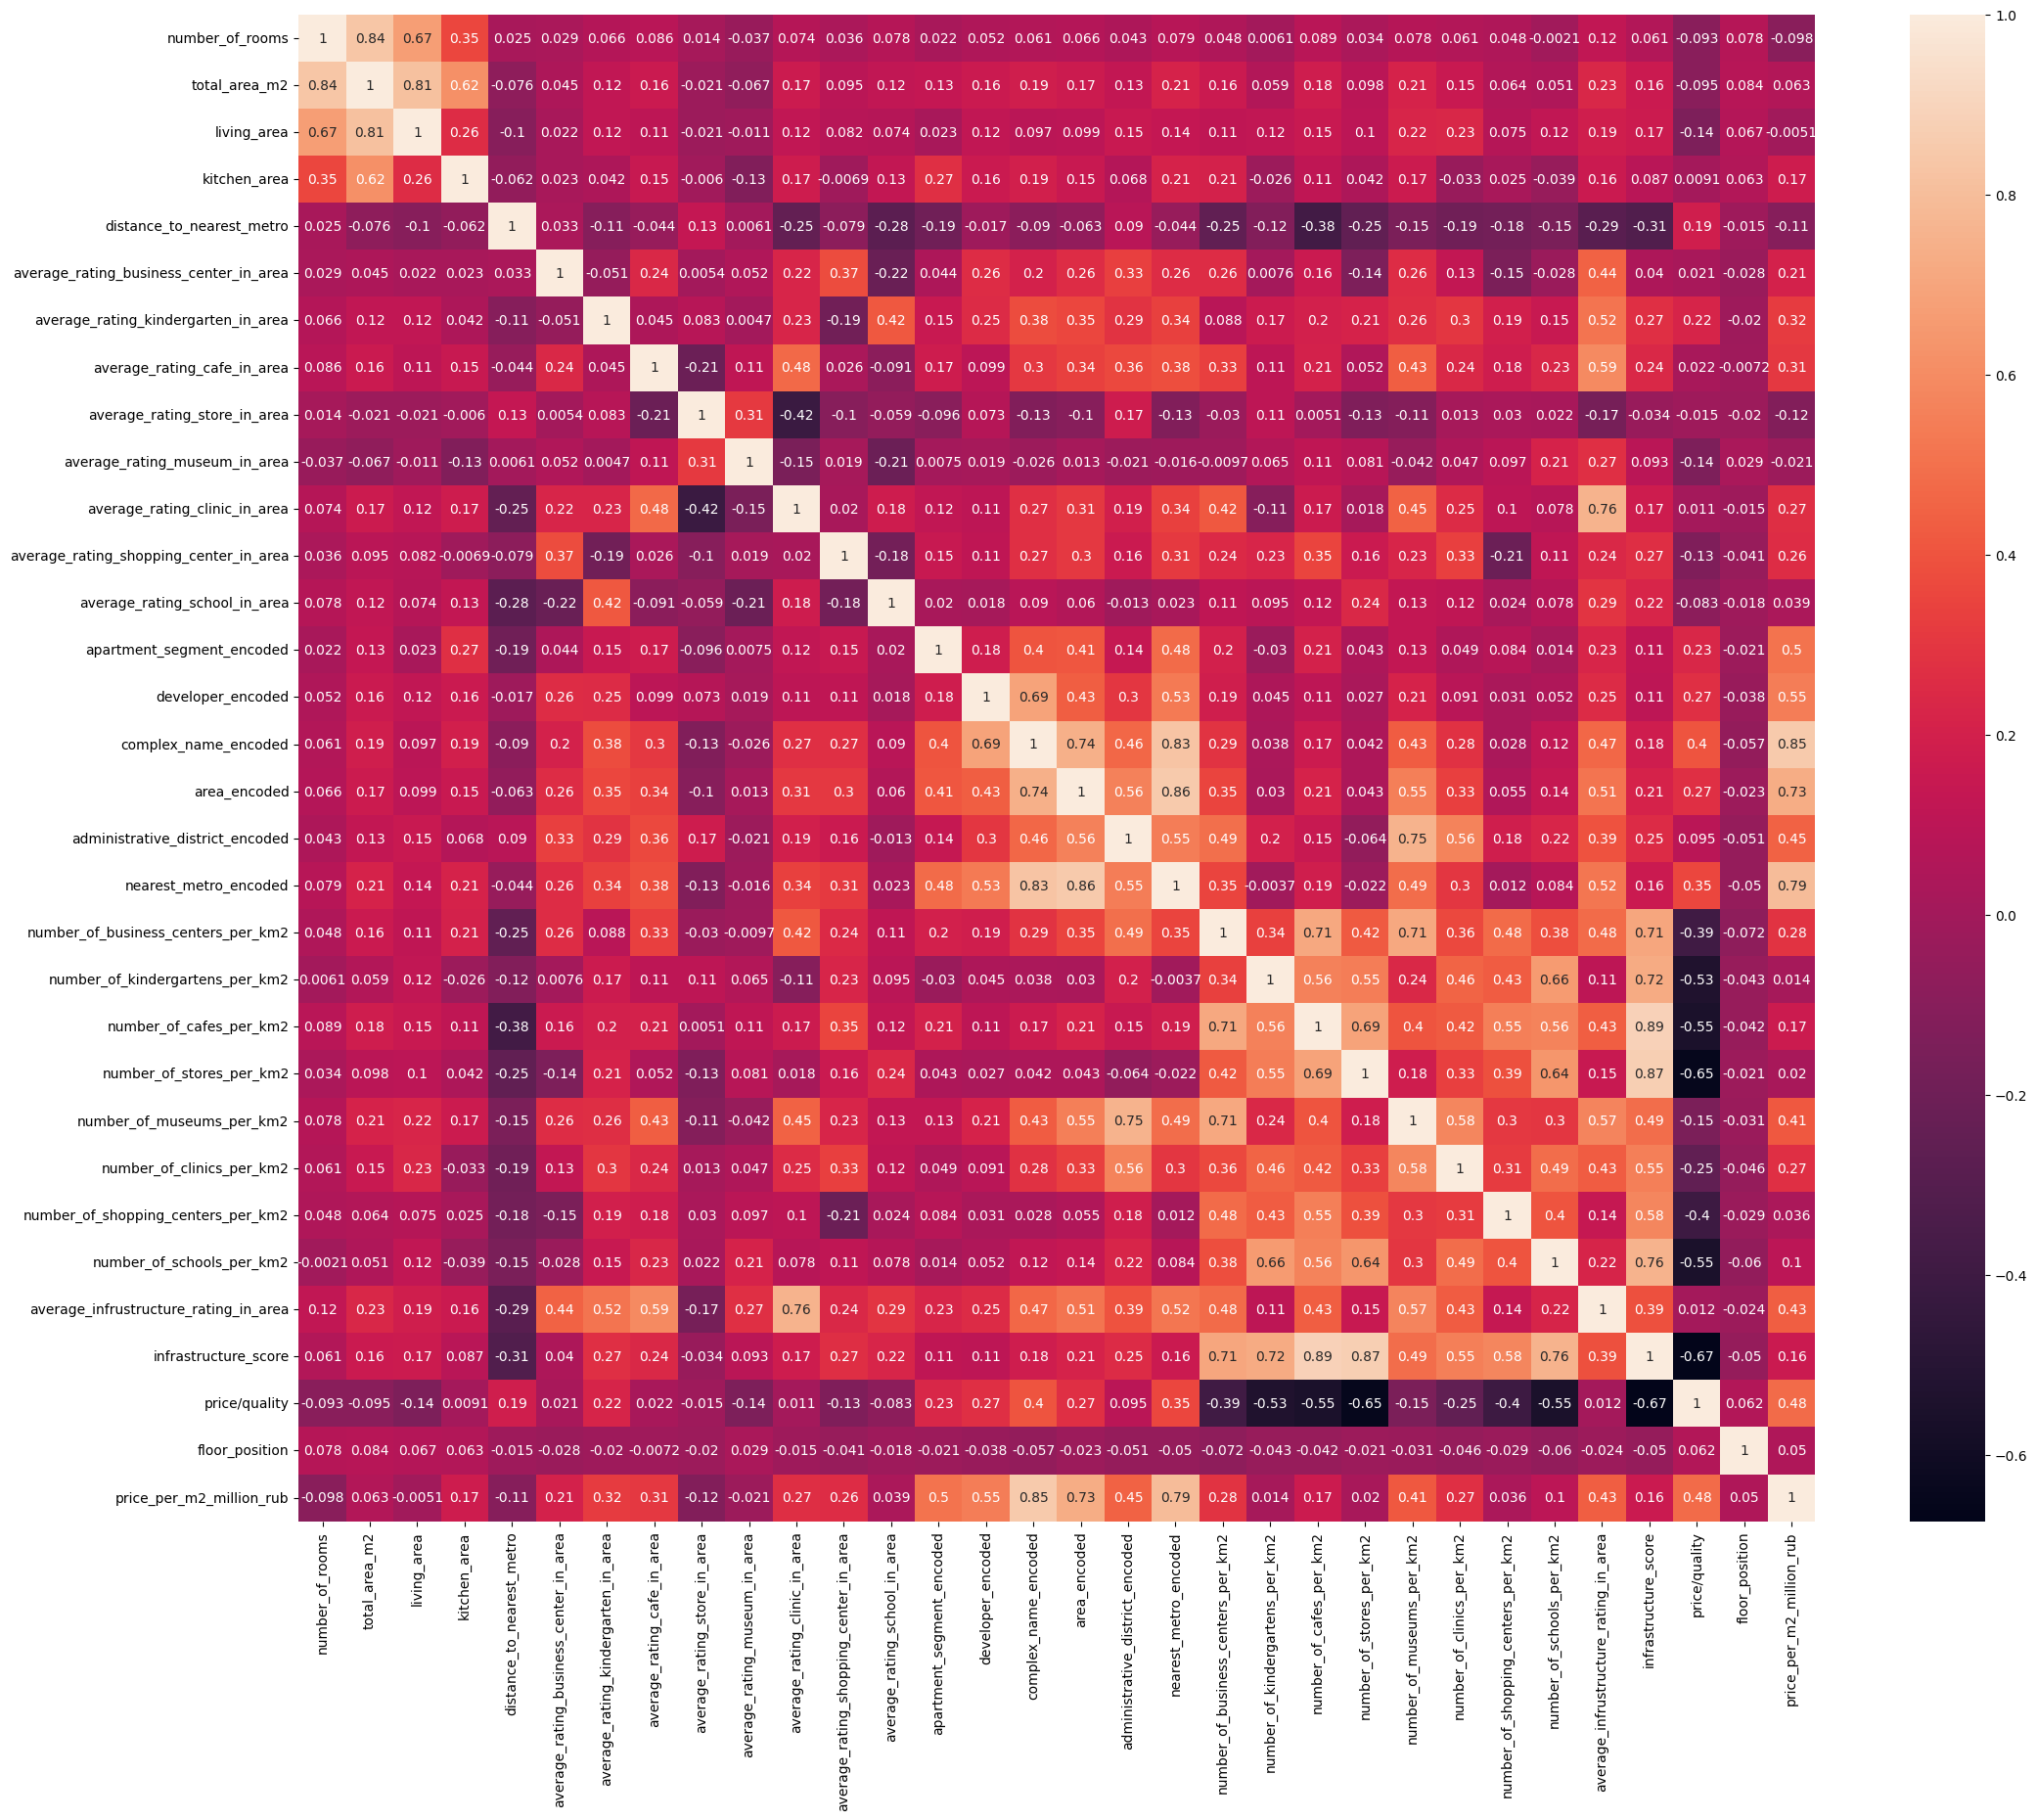

In [166]:
plt.figure(figsize=(25,20))
sns.heatmap(arr1.corr(numeric_only = True), annot=True)

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [168]:
arr1.isna().sum()

,0
complex_name,0
developer,0
apartment_segment,0
number_of_rooms,0
total_area_m2,0
living_area,190
kitchen_area,1333
nearest_metro,0
distance_to_nearest_metro,0
link,0


In [169]:
arr1.columns

Index(['complex_name', 'developer', 'apartment_segment', 'number_of_rooms',
       'total_area_m2', 'living_area', 'kitchen_area', 'nearest_metro',
       'distance_to_nearest_metro', 'link', 'administrative_district', 'area',
       'average_rating_business_center_in_area',
       'average_rating_kindergarten_in_area', 'average_rating_cafe_in_area',
       'average_rating_store_in_area', 'average_rating_museum_in_area',
       'average_rating_clinic_in_area',
       'average_rating_shopping_center_in_area',
       'average_rating_school_in_area', 'apartment_segment_encoded',
       'developer_encoded', 'complex_name_encoded', 'area_encoded',
       'administrative_district_encoded', 'nearest_metro_encoded',
       'number_of_business_centers_per_km2', 'number_of_kindergartens_per_km2',
       'number_of_cafes_per_km2', 'number_of_stores_per_km2',
       'number_of_museums_per_km2', 'number_of_clinics_per_km2',
       'number_of_shopping_centers_per_km2', 'number_of_schools_per_km2',
 

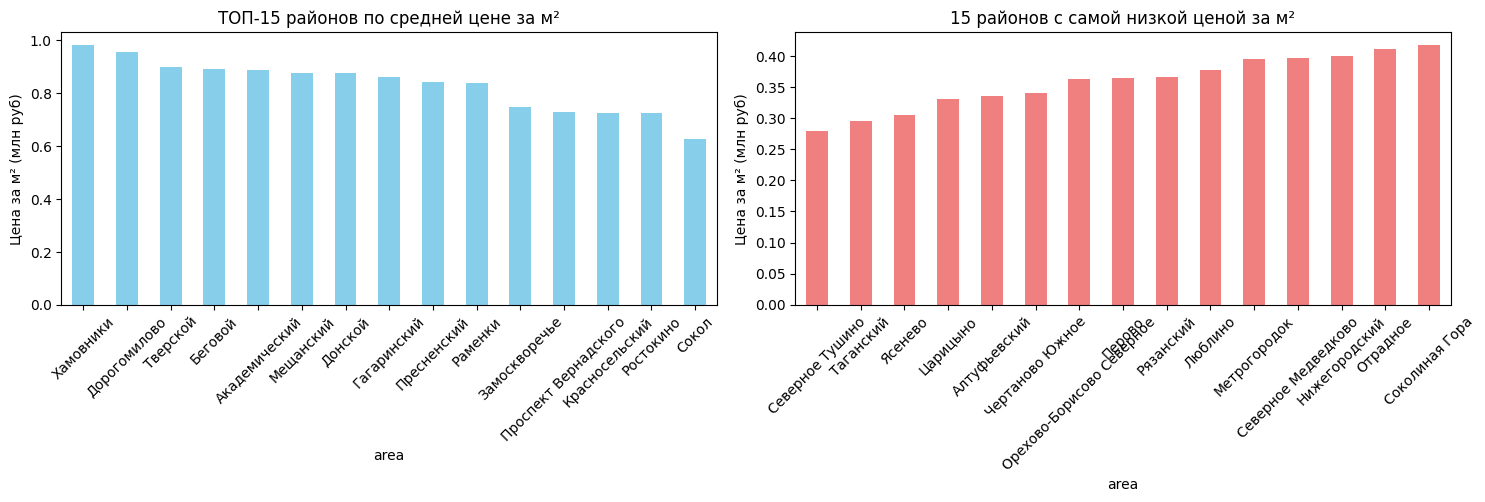

In [170]:
# 1. Анализ распределения цен по районам
plt.figure(figsize=(15, 8))
price_by_area = arr1.groupby('area')['price_per_m2_million_rub'].mean().sort_values(ascending=False)
plt.subplot(2, 2, 1)
price_by_area.head(15).plot(kind='bar', color='skyblue')
plt.title('ТОП-15 районов по средней цене за м²')
plt.ylabel('Цена за м² (млн руб)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
price_by_area.tail(15).sort_values(ascending=True).plot(kind='bar', color='lightcoral')
plt.title('15 районов с самой низкой ценой за м²')
plt.ylabel('Цена за м² (млн руб)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


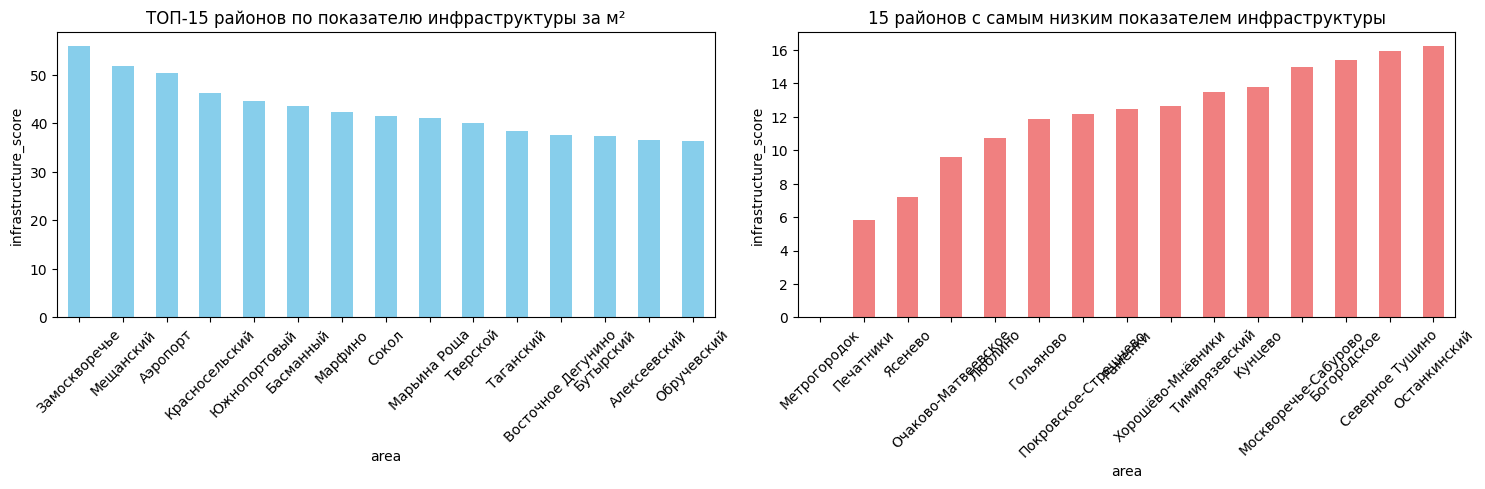

In [171]:
# 1. Анализ распределения уровня инфраструктуры по районам
plt.figure(figsize=(15, 8))
price_by_area = arr1.groupby('area')['infrastructure_score'].mean().sort_values(ascending=False)
plt.subplot(2, 2, 1)
price_by_area.head(15).plot(kind='bar', color='skyblue')
plt.title('ТОП-15 районов по показателю инфраструктуры за м²')
plt.ylabel('infrastructure_score')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
price_by_area.tail(15).sort_values(ascending=True).plot(kind='bar', color='lightcoral')
plt.title('15 районов с самым низким показателем инфраструктуры')
plt.ylabel('infrastructure_score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


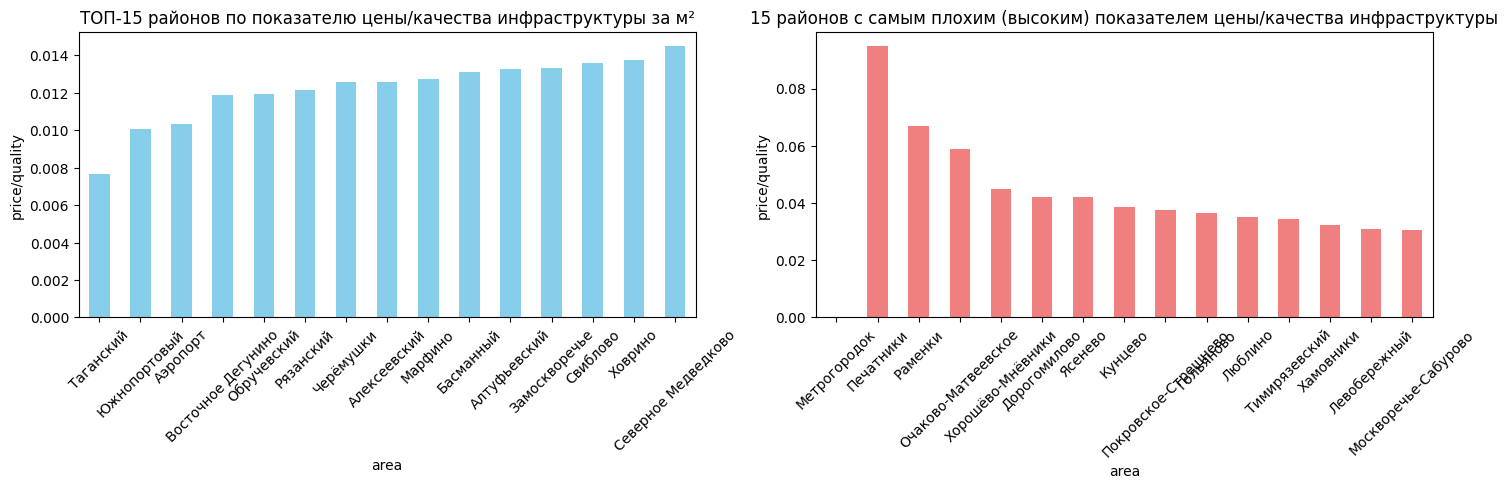

In [172]:
# 1. Анализ распределения цены/качества инфраструктуры по районам
plt.figure(figsize=(15, 8))
price_by_area = arr1.groupby('area')['price/quality'].mean().sort_values(ascending=False)
plt.subplot(2, 2, 1)
price_by_area.tail(15).sort_values(ascending=True).plot(kind='bar', color='skyblue')
plt.title('ТОП-15 районов по показателю цены/качества инфраструктуры за м²')
plt.ylabel('price/quality')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
price_by_area.head(15).plot(kind='bar', color='lightcoral')
plt.title('15 районов с самым плохим (высоким) показателем цены/качества инфраструктуры')
plt.ylabel('price/quality')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

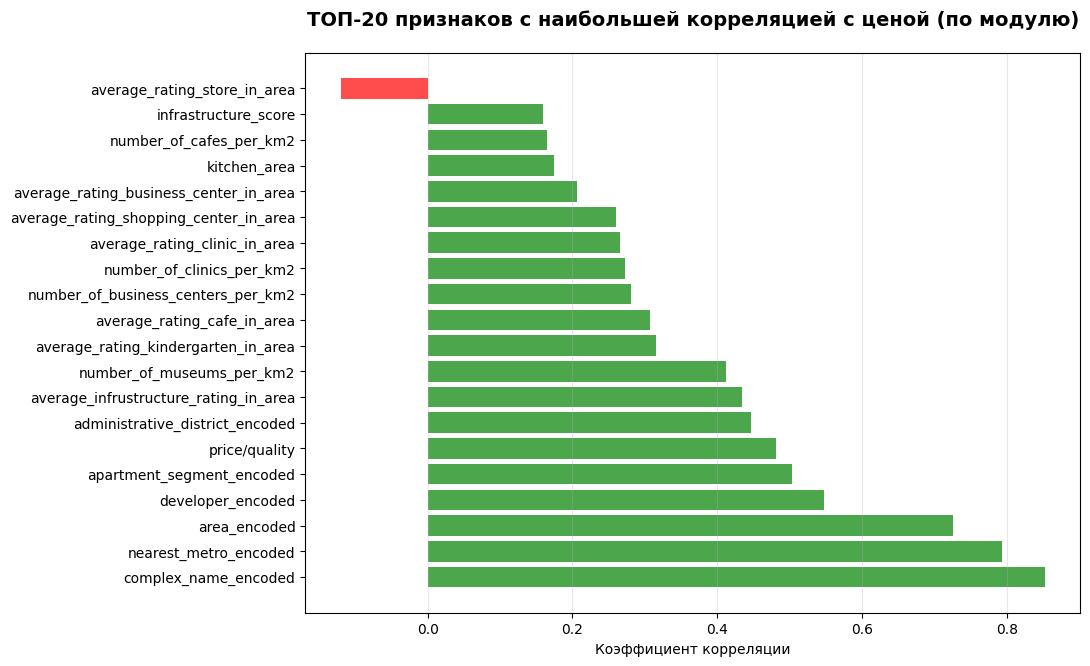

In [173]:
# Вычисляем корреляции с целевой переменной
correlations = arr1.corr(numeric_only=True)['price_per_m2_million_rub']

# Удаляем саму целевую переменную из списка (корреляция = 1)
correlations = correlations[correlations.index != 'price_per_m2_million_rub']

# Сортируем по модулю (абсолютному значению)
correlations_abs = correlations.abs().sort_values(ascending=False)

# Создаем фигуру и оси
fig, axes = plt.subplots(2, 2, figsize=(22, 16))

# 1. ТОП-20 корреляций по модулю
top_20_abs = correlations_abs.head(20)
# Получаем фактические значения корреляций для топ-20 по модулю
top_20_actual = correlations[top_20_abs.index]

colors = ['green' if x > 0 else 'red' for x in top_20_actual.values]

axes[0, 0].barh(range(len(top_20_actual)), top_20_actual.values, color=colors, alpha=0.7)
axes[0, 0].set_yticks(range(len(top_20_actual)))
axes[0, 0].set_yticklabels(top_20_actual.index, fontsize=10)
axes[0, 0].set_xlabel('Коэффициент корреляции')
axes[0, 0].set_title('ТОП-20 признаков с наибольшей корреляцией с ценой (по модулю)',
                     fontsize=14, fontweight='bold', pad=20)
axes[0, 0].grid(axis='x', alpha=0.3)

axes[1, 0].set_visible(False)
axes[1, 1].set_visible(False)
axes[0, 1].set_visible(False)


